In [35]:
#  ___________________________________________________________________________
#
#  Pyomo: Python Optimization Modeling Objects
#  Copyright (c) 2008-2025
#  National Technology and Engineering Solutions of Sandia, LLC
#  Under the terms of Contract DE-NA0003525 with National Technology and
#  Engineering Solutions of Sandia, LLC, the U.S. Government retains certain
#  rights in this software.
#  This software is distributed under the 3-clause BSD License.
#  ___________________________________________________________________________
"""
Prototype for multi-experiment optimization using the Rooney-Biegler example.
Testing trace (A-optimality) objective.
"""

import pyomo.environ as pyo
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.common.dependencies import pandas as pd, numpy as np


def rooney_biegler_model(data, theta=None):
    model = pyo.ConcreteModel()

    if theta is None:
        theta = {'asymptote': 15, 'rate_constant': 0.5}

    model.asymptote = pyo.Var(initialize=theta['asymptote'])
    model.rate_constant = pyo.Var(initialize=theta['rate_constant'])

    # Fix the unknown parameters
    model.asymptote.fix()
    model.rate_constant.fix()

    # Add the experiment inputs
    model.hour = pyo.Var(initialize=data["hour"].iloc[0], bounds=(0, 10))

    # Fix the experiment inputs
    model.hour.fix()

    # Add the response variable
    model.y = pyo.Var(within=pyo.PositiveReals, initialize=data["y"].iloc[0])

    def response_rule(m):
        return m.y == m.asymptote * (1 - pyo.exp(-m.rate_constant * m.hour))

    model.response_function = pyo.Constraint(rule=response_rule)

    return model


class RooneyBieglerExperiment(Experiment):

    def __init__(self, data, measure_error=None, theta=None):
        self.data = data
        self.model = None
        self.measure_error = measure_error
        self.theta = theta

    def create_model(self):
        # rooney_biegler_model expects a dataframe
        data_df = self.data.to_frame().transpose()
        self.model = rooney_biegler_model(data_df, theta=self.theta)

    def label_model(self):

        m = self.model

        # Add experiment outputs as a suffix
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update([(m.y, self.data['y'])])

        # Add unknown parameters as a suffix
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.value(k)) for k in [m.asymptote, m.rate_constant]
        )

        # Add measurement error as a suffix
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update([(m.y, self.measure_error)])

        # Add hour as an experiment input
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update([(m.hour, self.data['hour'])])

        # For multiple experiments, add symmetry breaking constraints
        m.sym_break_cons = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.sym_break_cons[m.hour] = None

    def get_labeled_model(self):
        self.create_model()
        self.label_model()
        return self.model


# Data Setup
data = pd.DataFrame(
    data=[[1, 8.3], [2, 10.3]],
    # data=[[1, 8.3], [2, 10.3], [3, 19.0], [4, 16.0], [5, 15.6], [7, 19.8]],
    columns=['hour', 'y'],
)
theta = {'asymptote': 15, 'rate_constant': 0.5}
measurement_error = 0.1


print(f"Creating {len(data)} experiments...")
FIM_0 = np.zeros((2, 2))
for i in range(len(data)):
    exp_data = data.loc[i, :]
    exp = RooneyBieglerExperiment(
        data=exp_data, theta=theta, measure_error=measurement_error
    )
    doe_obj = DesignOfExperiments(
        experiment_list=exp,
        objective_option='trace',
        prior_FIM=None,
        tee=False,
        _Cholesky_option=True,
        _only_compute_fim_lower=True,
    )
    FIM_0 += doe_obj.compute_FIM()

FIM_0

Creating 2 experiments...


array([[   55.43945226,  1055.6094328 ],
       [ 1055.6094328 , 20457.46766748]])

In [36]:
np.linalg.inv(FIM_0)

array([[ 1.03114692, -0.05320739],
       [-0.05320739,  0.00279439]])

In [37]:
np.linalg.det(FIM_0)

np.float64(19839.52756878617)

In [38]:
# Create DoE object with trace (A-optimality) objective
print(f"\nRunning optimization with trace (A-optimality) objective...")
doe_obj = DesignOfExperiments(
    experiment_list=exp,
    objective_option='determinant',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.run_doe()


Running optimization with trace (A-optimality) objective...


In [39]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'FIM': [[np.float64(154.09640262052633), np.float64(1155.9980712049944)],
  [np.float64(1155.9980712049944), np.float64(20559.618389588846)]],
 'Sensitivity Matrix': [[np.float64(0.9932620518098023),
   np.float64(1.0106964040178423)]],
 'Experiment Design': [9.999999646452407],
 'Experiment Design Names': ['hour'],
 'Experiment Outputs': [14.913829707924474],
 'Experiment Output Names': ['y'],
 'Unknown Parameters': [15.014999999999999, 0.5],
 'Unknown Parameter Names': ['asymptote', 'rate_constant'],
 'Measurement Error': [14.913829707924474],
 'Measurement Error Names': ['y'],
 'Prior FIM': [[np.float64(55.43945226398449), np.float64(1055.6094328038394)],
  [np.float64(1055.6094328038394), np.float64(20457.46766747939)]],
 'Objective expression': 'determinant',
 'log10 A-opt': np.float64(-1.94662757632365

In [40]:
# Create DoE object with trace (A-optimality) objective
doe_obj = DesignOfExperiments(
    experiment_list=exp,
    objective_option='determinant',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)

# Run optimization
doe_obj.optimize_experiments()

In [41]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[154.0964026205188, 1155.9980712049276],
    [1155.9980712049276, 20559.61838958872]],
   'log10 A-opt': np.float64(-1.9466275763236482),
   'log10 pseudo A-opt': np.float64(4.31625799213747),
   'log10 D-opt': np.float64(6.262885568461118),
   'log10 E-opt': np.float64(1.9484937532988593),
   'FIM Condition Number': np.float64(232.2191664690094),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [9.999999646452407],
     'Experiment Outputs': [14.913829707924474],
     'Measurement Error': [14.913829707924474],
     'FIM': [[np.float64(98.6569503565343), np.float64(100.3886384010882)],
      [np.float64(100.3886384010882), np.float64(102.1507221093314)]],
     'Sensitivity Matrix': [[np.float64(0.9932620518097645),
       np.float64(1.0

**Both `run_doe()` and `optimize_experiments()` give the same result.**
# Multiple experiments
## D-opt

In [42]:
exp1= exp
exp2 = exp
exp2.model.hour = 0
doe_obj = DesignOfExperiments(
    experiment_list=[exp1, exp2],  # We can use it without initialization and still gives same answer
    objective_option='determinant',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.optimize_experiments(results_file="multiexp_results_dopt.json")

In [43]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[252.75335222783178, 1256.386754178559],
    [1256.386754178559, 20661.769203183634]],
   'log10 A-opt': np.float64(-2.24110940775806),
   'log10 pseudo A-opt': np.float64(4.320447954792004),
   'log10 D-opt': np.float64(6.561557362550065),
   'log10 E-opt': np.float64(2.244773279685326),
   'FIM Condition Number': np.float64(118.03499967758496),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [9.999998751094452],
     'Experiment Outputs': [14.913829662632654],
     'Measurement Error': [14.913829662632654],
     'FIM': [[np.float64(98.65694975731763), np.float64(100.38867404958027)],
      [np.float64(100.38867404958027), np.float64(102.15079527821376)]],
     'Sensitivity Matrix': [[np.float64(0.9932620487933567),
       np.float64(

# A-opt

In [44]:
exp1 = exp
exp2 = exp
exp2.model.hour = 0
doe_obj = DesignOfExperiments(
    experiment_list=[
        exp1,
        exp2,
    ],  # We can use it without initialization and still gives same answer
    objective_option='trace',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.optimize_experiments(results_file="multiexp_results_trace.json")

In [45]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[252.75326431877053, 1256.3919839810535],
    [1256.3919839810535, 20661.779937566578]],
   'log10 A-opt': np.float64(-2.241107727295565),
   'log10 pseudo A-opt': np.float64(4.320448175868228),
   'log10 D-opt': np.float64(6.561555903163793),
   'log10 E-opt': np.float64(2.2447715829752606),
   'FIM Condition Number': np.float64(118.03552532136754),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [9.999911183949832],
     'Experiment Outputs': [14.913825232936915],
     'Measurement Error': [14.913825232936915],
     'FIM': [[np.float64(98.65689115127537), np.float64(100.39216058120319)],
      [np.float64(100.39216058120319), np.float64(102.15795154854197)]],
     'Sensitivity Matrix': [[np.float64(0.9932617537752845),
       np.floa

## Pseudo A-opt

In [46]:
exp1 = exp
exp2 = exp
exp2.model.hour = 0
doe_obj = DesignOfExperiments(
    experiment_list=[
        exp1,
        exp2,
    ],  # We can use it without initialization and still gives same answer
    objective_option='pseudo_trace',
    prior_FIM=FIM_0,
    tee=False,
    _Cholesky_option=True,
    _only_compute_fim_lower=True,
)
doe_obj.optimize_experiments(results_file="multiexp_results_pseudotrace.json")

In [47]:
doe_obj.results

{'Solver Status': <SolverStatus.ok: 'ok'>,
 'Termination Condition': <TerminationCondition.optimal: 'optimal'>,
 'Termination Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found',
 'Scenarios': [{'Total FIM': [[135.53248526796423, 2452.422918072138],
    [2452.422918072138, 44817.737755652524]],
   'log10 A-opt': np.float64(-0.12452929826814298),
   'log10 pseudo A-opt': np.float64(4.6527612910842695),
   'log10 D-opt': np.float64(4.777290589352412),
   'log10 E-opt': np.float64(0.12454216806295738),
   'FIM Condition Number': np.float64(33744.75297079045),
   'Unknown Parameters': [15.014999999999999, 0.5],
   'Experiments': [{'Experiment Design': [2.0036736952925955],
     'Experiment Outputs': [9.50142709208644],
     'Measurement Error': [9.50142709208644],
     'FIM': [[np.float64(40.04303689567181), np.float64(698.3765004257822)],
      [np.float64(698.3765004257822), np.float64(12180.138523799527)]],
     'Sensitivity Matrix': [[np.float64(0.6327956771286122),
       np.float64(

# Sensitivity analysis for 2 experiments

In [48]:
#  ___________________________________________________________________________
#
#  Pyomo: Python Optimization Modeling Objects
#  Copyright (c) 2008-2025
#  National Technology and Engineering Solutions of Sandia, LLC
#  Under the terms of Contract DE-NA0003525 with National Technology and
#  Engineering Solutions of Sandia, LLC, the U.S. Government retains certain
#  rights in this software.
#  This software is distributed under the 3-clause BSD License.
#  ___________________________________________________________________________
"""
Serial version of FIM computation for all pairwise experiment combinations.
Notebook-compatible version without multiprocessing.
"""

import pyomo.environ as pyo
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.common.dependencies import pandas as pd, numpy as np
import time
import json
from pathlib import Path


def rooney_biegler_model(data, theta=None):
    model = pyo.ConcreteModel()

    if theta is None:
        theta = {'asymptote': 15, 'rate_constant': 0.5}

    model.asymptote = pyo.Var(initialize=theta['asymptote'])
    model.rate_constant = pyo.Var(initialize=theta['rate_constant'])

    # Fix the unknown parameters
    model.asymptote.fix()
    model.rate_constant.fix()

    # Add the experiment inputs
    model.hour = pyo.Var(initialize=data["hour"].iloc[0], bounds=(0, 10))

    # Fix the experiment inputs
    model.hour.fix()

    # Add the response variable
    model.y = pyo.Var(within=pyo.PositiveReals, initialize=data["y"].iloc[0])

    def response_rule(m):
        return m.y == m.asymptote * (1 - pyo.exp(-m.rate_constant * m.hour))

    model.response_function = pyo.Constraint(rule=response_rule)

    return model


class RooneyBieglerExperiment(Experiment):

    def __init__(self, data, measure_error=None, theta=None):
        self.data = data
        self.model = None
        self.measure_error = measure_error
        self.theta = theta

    def create_model(self):
        # rooney_biegler_model expects a dataframe
        data_df = self.data.to_frame().transpose()
        self.model = rooney_biegler_model(data_df, theta=self.theta)

    def label_model(self):

        m = self.model

        # Add experiment outputs as a suffix
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update([(m.y, self.data['y'])])

        # Add unknown parameters as a suffix
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.value(k)) for k in [m.asymptote, m.rate_constant]
        )

        # Add measurement error as a suffix
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update([(m.y, self.measure_error)])

        # Add hour as an experiment input
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update([(m.hour, self.data['hour'])])

        # For multiple experiments, we need to add symmetry breaking constraints
        m.sym_break_cons = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.sym_break_cons[m.hour] = None

    def get_labeled_model(self):
        self.create_model()
        self.label_model()
        return self.model


def compute_fim_combination(args):
    """
    Compute FIM for a combination of experiments.

    Parameters
    ----------
    args : tuple
        (indices, hours, theta, measurement_error)
        where indices is a tuple of experiment indices,
        and hours is a tuple of corresponding hour values

    Returns
    -------
    dict
        Results dictionary containing hour values, indices, FIM, and log10_det
    """
    indices, hours, theta, measurement_error = args

    # Compute FIM sequentially, using each previous FIM as prior
    prior_FIM = FIM_0
    for idx, hour_val in enumerate(hours):
        # Create data series for this hour value
        data = pd.Series({'hour': hour_val, 'y': 10.0})  # y value doesn't matter

        # Create experiment and DOE object
        exp_obj = RooneyBieglerExperiment(
            data=data, measure_error=measurement_error, theta=theta
        )
        doe_obj = DesignOfExperiments(experiment_list=[exp_obj], prior_FIM=prior_FIM)
        prior_FIM = doe_obj.compute_FIM()

    final_FIM = prior_FIM

    # Compute log10 determinant
    det_val = np.linalg.det(final_FIM)
    log10_det = float(np.log10(det_val)) if det_val > 0 else None

    # Build result dictionary with dynamic hour fields
    result = {
        'indices': [int(i) for i in indices],
        'FIM': final_FIM.tolist(),  # Convert numpy array to list for JSON serialization
        'log10_det': log10_det,
    }

    # Add hour fields dynamically (hour1, hour2, hour3, etc.)
    for idx, hour_val in enumerate(hours, 1):
        result[f'hour{idx}'] = float(hour_val)

    return result


def run_serial(hours, theta, measurement_error, n_experiments=2):
    """Serial computation (notebook-compatible).

    Parameters
    ----------
    hours : array-like
        Array of hour values to use for experiments
    theta : dict
        Parameter values for the model
    measurement_error : float
        Measurement error for experiments
    n_experiments : int, optional
        Number of experiments in each combination (2, 3, or 4), default is 2

    Returns
    -------
    tuple
        (results, elapsed_time)
    """
    from itertools import combinations_with_replacement

    tasks = []
    for indices in combinations_with_replacement(range(len(hours)), n_experiments):
        hour_values = tuple(hours[i] for i in indices)
        tasks.append((indices, hour_values, theta, measurement_error))

    start_time = time.time()
    
    # Compute serially with progress indicator
    results = []
    total = len(tasks)
    print_interval = max(1, total // 20)  # Print progress ~20 times
    
    for i, task in enumerate(tasks):
        if i % print_interval == 0:
            print(f"Progress: {i}/{total} ({100*i/total:.1f}%)")
        results.append(compute_fim_combination(task))
    
    elapsed = time.time() - start_time
    print(f"Progress: {total}/{total} (100.0%)")
    
    return results, elapsed


# Create hour data with dense sampling around optimal region for verification
# Optimal from optimization: hour1≈1.90, hour2≈10.0
hours_p1 = np.linspace(0.1, 1.7, 5)  # Before optimal: coarse
hours_p2 = np.linspace(1.71, 2.1, 5)  # Around optimal hour1: dense
hours_p3 = np.linspace(2.2, 9.4, 5)  # Between: coarse
hours_p4 = np.linspace(9.41, 10, 5)  # Around optimal hour2: dense
hours = np.concatenate((hours_p1, hours_p2, hours_p3, hours_p4))

# Set number of experiments (2, 3, or 4)
n_experiments = 2

# Calculate number of combinations
from math import comb

n_combinations = comb(len(hours) + n_experiments - 1, n_experiments)

print(f"\nVerification Grid Setup:")
print(f"  Total points: {len(hours)}")
print(f"  Range: [{hours[0]:.2f}, {hours[-1]:.2f}]")
print(f"  Dense around hour1≈1.90: [1.71, 2.10] with {len(hours_p2)} points")
print(f"  Dense around hour2≈10.0: [9.41, 10.00] with {len(hours_p4)} points")
print(f"  Number of experiments per combination: {n_experiments}")
print(f"  Total combinations: {n_combinations}")

theta = {'asymptote': 15, 'rate_constant': 0.5}
measurement_error = 0.1

print(f"\nComputing FIM for verification (serial computation)...\n")

# Run serial computation
results_serial, time_serial = run_serial(
    hours, theta, measurement_error, n_experiments
)

print(f"\nComputation completed in {time_serial:.2f} seconds\n")

# Save results to JSON file
file_name = f"rooney_biegler_fim_{n_experiments}exp_verification_notebook.json"
DATA_DIR = Path.cwd()
output_file = DATA_DIR / file_name
print(f"Saving results to {output_file}...")

output_data = {
    'metadata': {
        'n_experiments': n_experiments,
        'n_hours': len(hours),
        'hour_range': [float(hours[0]), float(hours[-1])],
        'total_computations': len(results_serial),
        'theta': theta,
        'measurement_error': measurement_error,
        'computation_method': 'serial',
        'computation_time': time_serial,
        'grid_description': 'Dense sampling around optimal regions (1.71-2.10, 9.41-10), coarse elsewhere',
    },
    'results': results_serial,
}

with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

file_size_mb = len(json.dumps(output_data)) / 1024 / 1024
print(f"Results saved! File size: {file_size_mb:.2f} MB")

# Quick analysis
results_df = pd.DataFrame(results_serial)
valid_results = results_df[results_df['log10_det'].notna()].copy()

print(f"\nValid combinations (det > 0): {len(valid_results)} / {len(results_df)}")

if len(valid_results) > 0:
    best_idx = valid_results['log10_det'].idxmax()
    best = valid_results.loc[best_idx]
    print("\n" + "=" * 70)
    print("GRID SEARCH VERIFICATION OF OPTIMIZATION RESULT")
    print("=" * 70)

    # Print hour values dynamically
    hour_str = ", ".join(
        [f"Hour{i}={best[f'hour{i}']:.4f}" for i in range(1, n_experiments + 1)]
    )
    print(f"Best design from grid: {hour_str}")
    print(f"                       log10(det) = {best['log10_det']:.4f}")
    print("=" * 70 + "\n")



Verification Grid Setup:
  Total points: 20
  Range: [0.10, 10.00]
  Dense around hour1≈1.90: [1.71, 2.10] with 5 points
  Dense around hour2≈10.0: [9.41, 10.00] with 5 points
  Number of experiments per combination: 2
  Total combinations: 210

Computing FIM for verification (serial computation)...

Progress: 0/210 (0.0%)
Progress: 10/210 (4.8%)
Progress: 20/210 (9.5%)
Progress: 30/210 (14.3%)
Progress: 40/210 (19.0%)
Progress: 50/210 (23.8%)
Progress: 60/210 (28.6%)
Progress: 70/210 (33.3%)
Progress: 80/210 (38.1%)
Progress: 90/210 (42.9%)
Progress: 100/210 (47.6%)
Progress: 110/210 (52.4%)
Progress: 120/210 (57.1%)
Progress: 130/210 (61.9%)
Progress: 140/210 (66.7%)
Progress: 150/210 (71.4%)
Progress: 160/210 (76.2%)
Progress: 170/210 (81.0%)
Progress: 180/210 (85.7%)
Progress: 190/210 (90.5%)
Progress: 200/210 (95.2%)
Progress: 210/210 (100.0%)

Computation completed in 31.95 seconds

Saving results to /Users/smondal/Documents/Github/pyomo/pyomo/contrib/doe/examples/multiexperimen

# Plotting results from the optimization and sensitivity

Optimization result from multiexp_results_dopt.json:
  Hour1: 10.0000, Hour2: 10.0000

Loaded 210 results
Computing FIM metrics for all results...

Valid results: 210

Best D-optimality design:
  Hour1: 10.0000, Hour2: 10.0000
  log10(det): 6.8649

Best A-optimality design (minimize trace of covariance):
  Hour1: 10.0000, Hour2: 10.0000
  log10(trace(cov)): -2.2477

Best Pseudo-A-optimality design (maximize trace of FIM):
  Hour1: 2.0025, Hour2: 2.0025
  log10(trace(FIM)): 4.8160

Grid size: 20 x 20

Plot saved as '/Users/smondal/Documents/Github/pyomo/pyomo/contrib/doe/examples/multiexperiment-prototype/rooney_biegler_fim_metrics_plot.png'


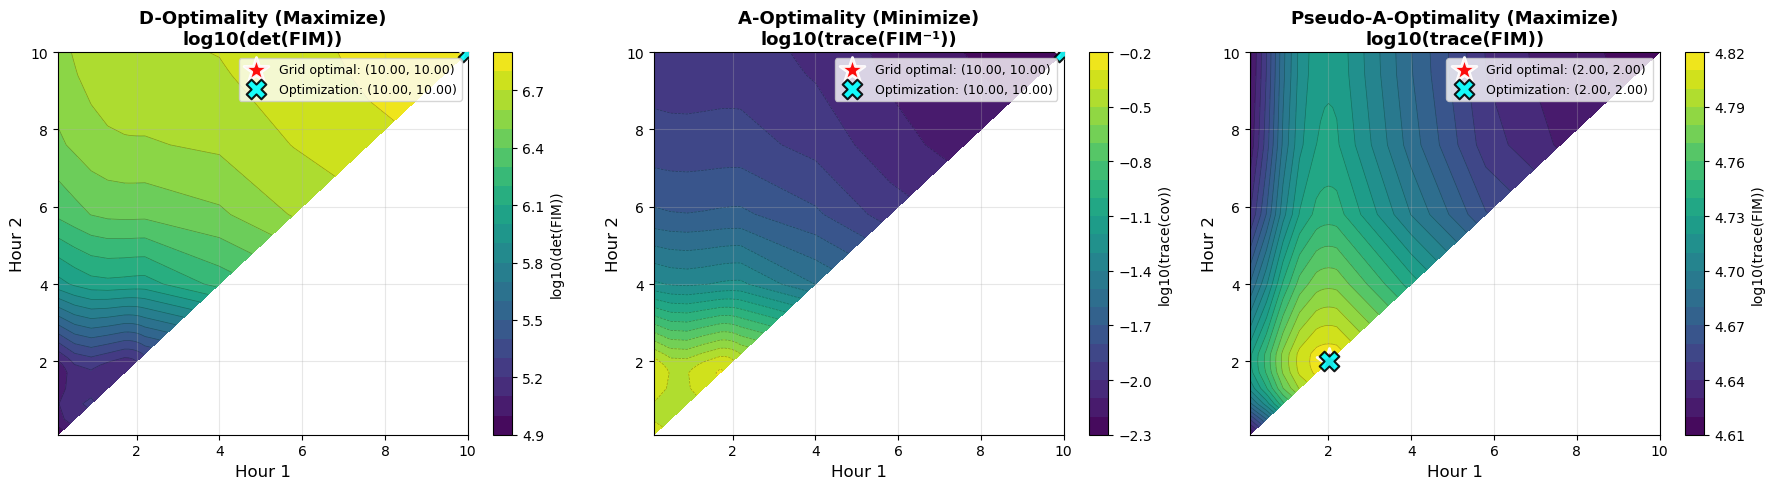

In [49]:
"""
Plot FIM results from rooney_biegler_fim_2exp_verification.json
Creates 2D contour plots for D-optimality, A-optimality, and Pseudo-A-optimality
"""

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import sys
from pyomo.contrib.parmest.examples.rooney_biegler.rooney_biegler import (
    RooneyBieglerExperiment,
)
from pyomo.contrib.doe import DesignOfExperiments

# Add the parent directory to the path to import from pyomo.contrib.doe
# sys.path.insert(0, str(Path(__file__).parent.parent.parent.parent))
from pyomo.contrib.doe.utils import compute_FIM_metrics

# Get the directory where this script is located
script_dir = Path.cwd()

# Read the results file from the sensitivity analysis
with open(script_dir / 'rooney_biegler_fim_2exp_verification_notebook.json', 'r') as f:
    data = json.load(f)

# Read the optimization results
with open(script_dir / 'multiexp_results_dopt.json', 'r') as f:
    opt_results = json.load(f)

# Extract optimal hour values from optimization
opt_hour1_dopt = opt_results['Scenarios'][0]['Experiments'][0]['Experiment Design'][0]
opt_hour2_dopt = opt_results['Scenarios'][0]['Experiments'][1]['Experiment Design'][0]

with open(script_dir / 'multiexp_results_trace.json', 'r') as f:
    opt_results = json.load(f)

# Extract optimal hour values from optimization
opt_hour1_trace = opt_results['Scenarios'][0]['Experiments'][0]['Experiment Design'][0]
opt_hour2_trace = opt_results['Scenarios'][0]['Experiments'][1]['Experiment Design'][0]

with open(script_dir / 'multiexp_results_pseudotrace.json', 'r') as f:
    opt_results = json.load(f)

# Extract optimal hour values from optimization
opt_hour1_pseudotrace = opt_results['Scenarios'][0]['Experiments'][0]['Experiment Design'][0]
opt_hour2_pseudotrace = opt_results['Scenarios'][0]['Experiments'][1]['Experiment Design'][0]


print(f"Optimization result from multiexp_results_dopt.json:")
print(f"  Hour1: {opt_hour1_dopt:.4f}, Hour2: {opt_hour2_dopt:.4f}\n")
# Convert results to DataFrame
results_df = pd.DataFrame(data['results'])

print(f"Loaded {len(results_df)} results")
print(f"Computing FIM metrics for all results...\n")
# Compute metrics for each result
d_optimality = []
a_optimality = []
pseudo_a_optimality = []

for idx, row in results_df.iterrows():
    if row['log10_det'] is not None:
        FIM = np.array(row['FIM']) + FIM_0 # Add prior FIM
        try:
            (
                det_FIM,
                trace_cov,
                trace_FIM,
                E_vals,
                E_vecs,
                D_opt,
                A_opt,
                pseudo_A_opt,
                E_opt,
                ME_opt,
            ) = compute_FIM_metrics(FIM)

            d_optimality.append(D_opt)
            a_optimality.append(A_opt)
            pseudo_a_optimality.append(pseudo_A_opt)
        except:
            d_optimality.append(np.nan)
            a_optimality.append(np.nan)
            pseudo_a_optimality.append(np.nan)
    else:
        d_optimality.append(np.nan)
        a_optimality.append(np.nan)
        pseudo_a_optimality.append(np.nan)

# Add metrics to dataframe
results_df['D_optimality'] = d_optimality
results_df['A_optimality'] = a_optimality
results_df['pseudo_A_optimality'] = pseudo_a_optimality

# Find optimal values for each metric
# D-optimality: maximize
valid_d = results_df[results_df['D_optimality'].notna()].copy()
best_d_idx = valid_d['D_optimality'].idxmax()
best_d = valid_d.loc[best_d_idx]

# A-optimality: minimize (trace of covariance)
valid_a = results_df[results_df['A_optimality'].notna()].copy()
best_a_idx = valid_a['A_optimality'].idxmin()
best_a = valid_a.loc[best_a_idx]

# Pseudo-A-optimality: maximize (trace of FIM)
valid_pa = results_df[results_df['pseudo_A_optimality'].notna()].copy()
best_pa_idx = valid_pa['pseudo_A_optimality'].idxmax()
best_pa = valid_pa.loc[best_pa_idx]

print(f"Valid results: {len(valid_d)}")
print(f"\nBest D-optimality design:")
print(f"  Hour1: {best_d['hour1']:.4f}, Hour2: {best_d['hour2']:.4f}")
print(f"  log10(det): {best_d['D_optimality']:.4f}")

print(f"\nBest A-optimality design (minimize trace of covariance):")
print(f"  Hour1: {best_a['hour1']:.4f}, Hour2: {best_a['hour2']:.4f}")
print(f"  log10(trace(cov)): {best_a['A_optimality']:.4f}")

print(f"\nBest Pseudo-A-optimality design (maximize trace of FIM):")
print(f"  Hour1: {best_pa['hour1']:.4f}, Hour2: {best_pa['hour2']:.4f}")
print(f"  log10(trace(FIM)): {best_pa['pseudo_A_optimality']:.4f}")


# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Get unique hour values and create grid
hour1_unique = np.unique(results_df['hour1'])
hour2_unique = np.unique(results_df['hour2'])

print(f"\nGrid size: {len(hour1_unique)} x {len(hour2_unique)}")

# Create meshgrid
H1, H2 = np.meshgrid(hour1_unique, hour2_unique)


# Helper function to create grid for metric
def create_metric_grid(df, metric_name):
    Z = np.full(H1.shape, np.nan)
    for idx, row in df.iterrows():
        i = np.where(hour2_unique == row['hour2'])[0][0]
        j = np.where(hour1_unique == row['hour1'])[0][0]
        Z[i, j] = row[metric_name] if not np.isnan(row[metric_name]) else np.nan
    return Z


# 1. D-optimality plot
ax1 = axes[0]
Z_d = create_metric_grid(results_df, 'D_optimality')
contour1 = ax1.contourf(H1, H2, Z_d, levels=20, cmap='viridis')
ax1.contour(H1, H2, Z_d, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax1.scatter(
    [best_d['hour1']],
    [best_d['hour2']],
    color='red',
    s=350,
    marker='*',
    edgecolors='white',
    linewidths=2,
    alpha=0.95,
    label=f'Grid optimal: ({best_d["hour1"]:.2f}, {best_d["hour2"]:.2f})',
    zorder=5,
)
# Plot optimal point from optimize_experiments()
ax1.scatter(
    opt_hour1_dopt,
    opt_hour2_dopt,
    color='cyan',
    s=200,
    marker='X',
    edgecolors='black',
    linewidths=1.5,
    alpha=0.9,
    label=f'Optimization: ({opt_hour1_dopt:.2f}, {opt_hour2_dopt:.2f})',
    zorder=5,
)
ax1.set_xlabel('Hour 1', fontsize=12)
ax1.set_ylabel('Hour 2', fontsize=12)
ax1.set_title(
    'D-Optimality (Maximize)\nlog10(det(FIM))', fontsize=13, fontweight='bold'
)
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)
fig.colorbar(contour1, ax=ax1, label='log10(det(FIM))')

# 2. A-optimality plot
ax2 = axes[1]
Z_a = create_metric_grid(results_df, 'A_optimality')
contour2 = ax2.contourf(H1, H2, Z_a, levels=20, cmap='viridis')
ax2.contour(H1, H2, Z_a, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax2.scatter(
    [best_a['hour1']],
    [best_a['hour2']],
    color='red',
    s=350,
    marker='*',
    edgecolors='white',
    linewidths=2,
    alpha=0.95,
    label=f'Grid optimal: ({best_a["hour1"]:.2f}, {best_a["hour2"]:.2f})',
    zorder=5,
)
ax2.scatter(
    opt_hour1_trace,
    opt_hour2_trace,
    color='cyan',
    s=200,
    marker='X',
    edgecolors='black',
    linewidths=1.5,
    alpha=0.9,
    label=f'Optimization: ({opt_hour1_trace:.2f}, {opt_hour2_trace:.2f})',
    zorder=5,
)
ax2.set_xlabel('Hour 1', fontsize=12)
ax2.set_ylabel('Hour 2', fontsize=12)
ax2.set_title(
    'A-Optimality (Minimize)\nlog10(trace(FIM⁻¹))', fontsize=13, fontweight='bold'
)
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
fig.colorbar(contour2, ax=ax2, label='log10(trace(cov))')

# 3. Pseudo-A-optimality plot
ax3 = axes[2]
Z_pa = create_metric_grid(results_df, 'pseudo_A_optimality')
contour3 = ax3.contourf(H1, H2, Z_pa, levels=20, cmap='viridis')
ax3.contour(H1, H2, Z_pa, levels=20, colors='black', alpha=0.3, linewidths=0.5)
ax3.scatter(
    [best_pa['hour1']],
    [best_pa['hour2']],
    color='red',
    s=350,
    marker='*',
    edgecolors='white',
    linewidths=2,
    alpha=0.95,
    label=f'Grid optimal: ({best_pa["hour1"]:.2f}, {best_pa["hour2"]:.2f})',
    zorder=5,
)
ax3.scatter(
    opt_hour1_pseudotrace,
    opt_hour2_pseudotrace,
    color='cyan',
    s=200,
    marker='X',
    edgecolors='black',
    linewidths=1.5,
    alpha=0.9,
    label=f'Optimization: ({opt_hour1_pseudotrace:.2f}, {opt_hour2_pseudotrace:.2f})',
    zorder=5,
)


ax3.set_xlabel('Hour 1', fontsize=12)
ax3.set_ylabel('Hour 2', fontsize=12)
ax3.set_title(
    'Pseudo-A-Optimality (Maximize)\nlog10(trace(FIM))', fontsize=13, fontweight='bold'
)
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)
fig.colorbar(contour3, ax=ax3, label='log10(trace(FIM))')

plt.tight_layout()
output_path = script_dir / 'rooney_biegler_fim_metrics_plot.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nPlot saved as '{output_path}'")
plt.show()